## Databases with Python

<font color="gray"> AY250 (c 2008-2022) </font>


<div><center>
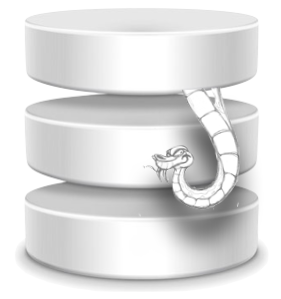
    </center>
</div>

```bash
pip install -U xarray dask bottleneck \
    pytables h5py sqlalchemy netCDF4
```

sqlite: https://www.sqlite.org/download.html

This work is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 3.0 Unported License.

## Overview of Today's Lecture

- What are DBs? Why DBs?

- Generic DB concepts: relational table architecture SQL

- sqlite3 & Python

- Postgresql

- HDF5/pytables, NetCDF4/xarray

## What are DBs? 

Organized collection of data, managed by a Database Management System (DBMS)


DBMSs (generally) offer:

 - storage
 - creation & manipulation of data
 - search
 - (high-level data operations)

Whaa? Doesn't Python already do this for me? E.g. Lists...

In [ ]:
# Creation
db = list(range(1,1000,2))
# manipulation
db[10] = "spamalot"

In [ ]:
# search
db.index(31)

In [ ]:
# storage
import pickle ; pickle.dump(db, open("my.py.db","wb+"))

Limitations:

- Searches on lists are slow, $\mathcal{O}(n)$
- db can only be as big as the available RAM
- efficiently storage files (ie., pickles) are python-only (portability issue)
- single-instance use only (no concurrent use by others)

Dictionaries solve some of simplest the searching issues (using a hash value for the key), but any realistic search is still painfully slow on big data:

In [ ]:
db = {"scenes": \
        [{"cheeseshop": {"actors": ["Cleese", "Palin"]}},  \
         {"spam":       {"actors": ["Cleese","Idle"]}}],  \
      "actors": \
         {"Palin":  {"age": 54, "how funny": 6}, \
          "Cleese": {"age": 62, "how funny": 9},  \
          "Idle":   {"age": 61, "how funny": None}}}

What's the average age of the actors in the cheeseshop scene?

(concept of a JOIN operation...see more later)

## Python "Solution" is to 3rd-Party It

provides built-in access to `sqlite3` & APIs for all other major DBMS

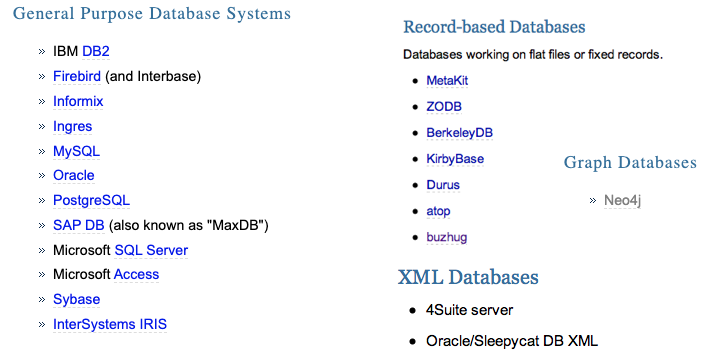

See: http://wiki.python.org/moin/DatabaseInterfaces

# Understanding DBMS Frameworks
Three levels:
1. External
    
    what "users" of the DB sees (ie., the Python API)
    usually different for different users
    
2. Conceptual

    logical structure of the DB, relationships between the data,
    security details, etc.  "DB Scheme"
    
3. Physical
    
    how the data are stored, managed at a low
    level (from compiled-language code to bytes)
    
<center>
    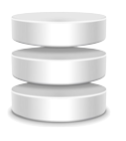</img>
</center>

## Implementation

How the conceptual level views data, the "data model":


**Relational**

Think of data organized as 2D tables, with connections between them (most)

**Object-Oriented**

Think of data as attributes in model classes, with methods & inheritance (e.g., db4o, ~BigTable)


**Hierarchical**

Tree- or document-like. XML/JSON DBs and "NoSQL" DBs (e.g., mongoDB, RethinkDB, DynamoDB)

**Relational**

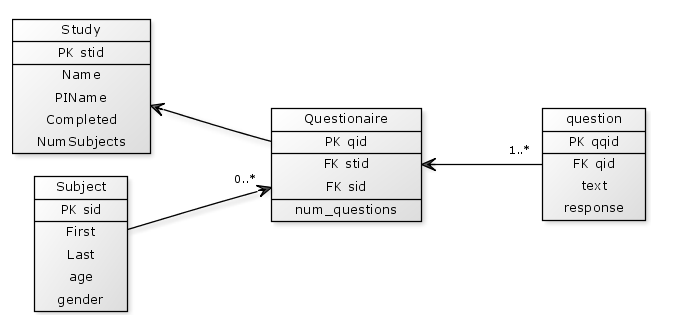

PK = Primary Key (Hashed)
FK = Foreign Key

**Object-Oriented**

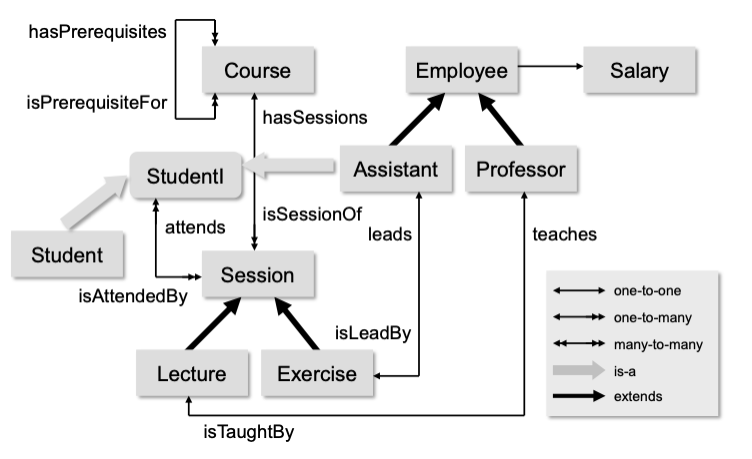

http://www.odbms.org/wp-content/uploads/2013/11/lecture_12_objectDatabases.pdf

**Hierarchical**
(think about HTML, LaTex, etc. documents)

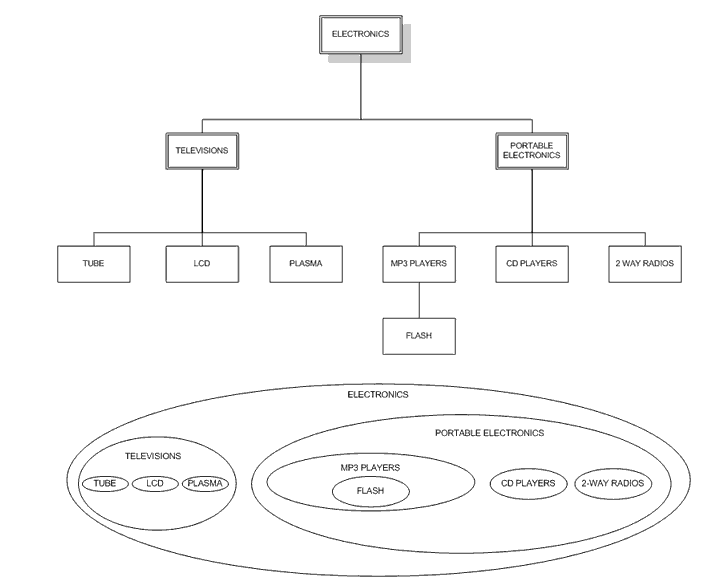

## How the DBMS operates:



**client-server** - 

persistent server managing and accepting connections from multiple clients. (could have a distributed and/or cloud implementation) [Postgresql, MongDB, ...]

**embedded** 

no server. Clients connect to the DB directly. [sqlite3]

<p>
&nbsp;&nbsp;
</p>
<center>
    <i>All modern DBMSs are meant to be 
fast, safe, very scalable:
        large, complex queries can be efficient</i></center>

# Data Model Concepts

**database** - contains tables, actions ("triggers"), permissions/security

**table** - data with fixed number of columns and rows of data that you add to (and query)

**keys** - hashed columns (or combinations of columns) used for efficiently joining of tables. "Primary" & "Foreign"

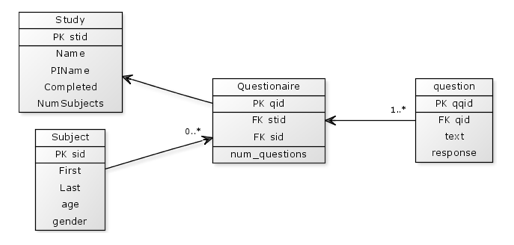

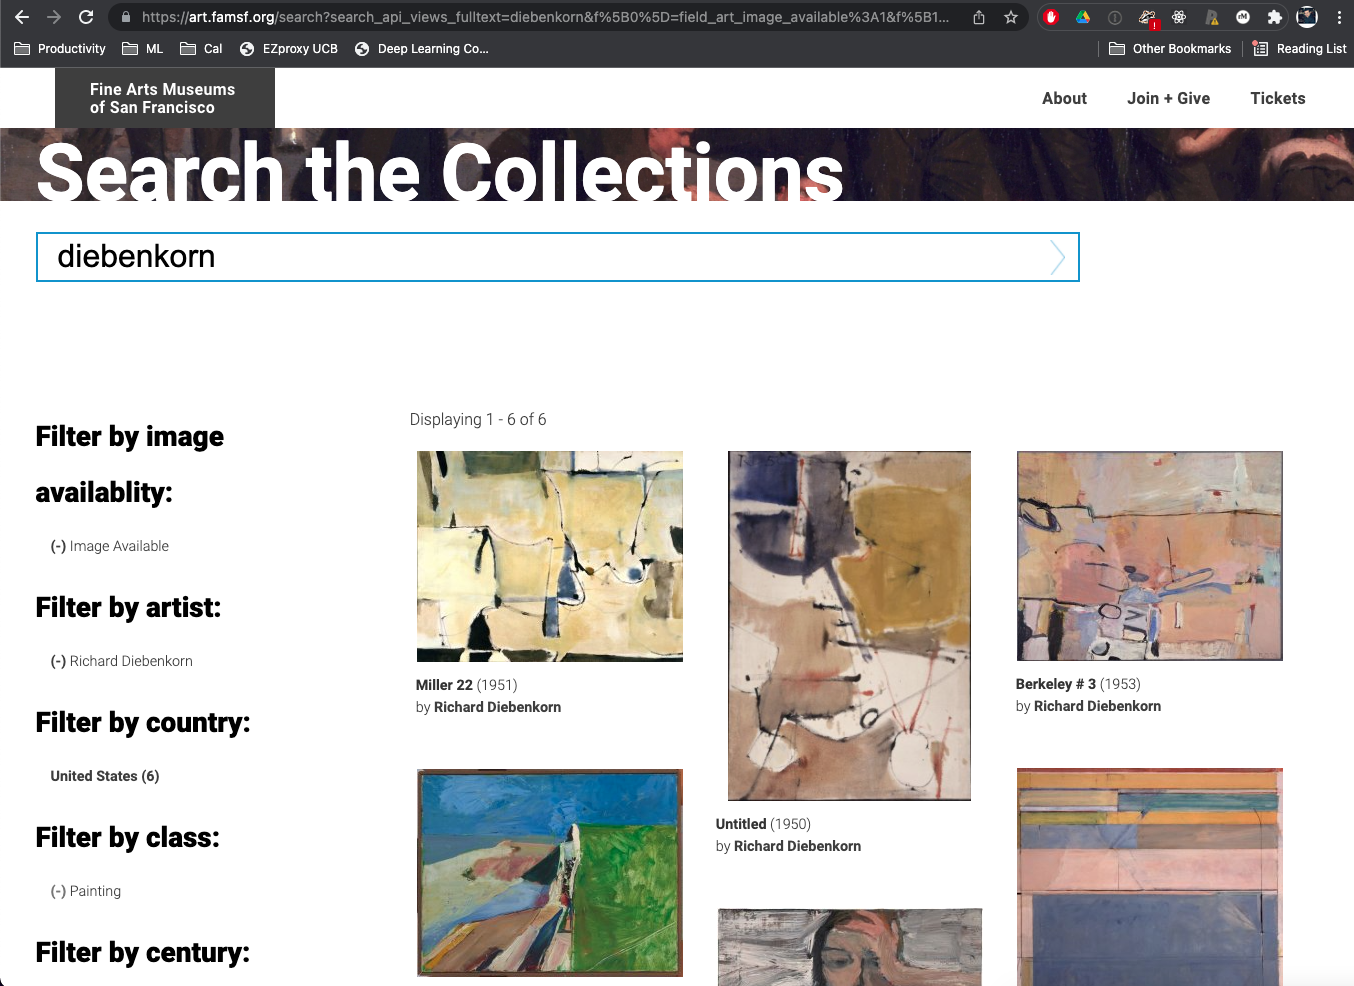

https://art.famsf.org/
see also: http://www.bampfa.berkeley.edu/search

# Simple (Command-Line) DB Creation with SQLite3

https://sqlite.org/cli.html

In [ ]:
%%bash
rm art.db
sqlite3 art.db ".read art-create.sql" ".schema"

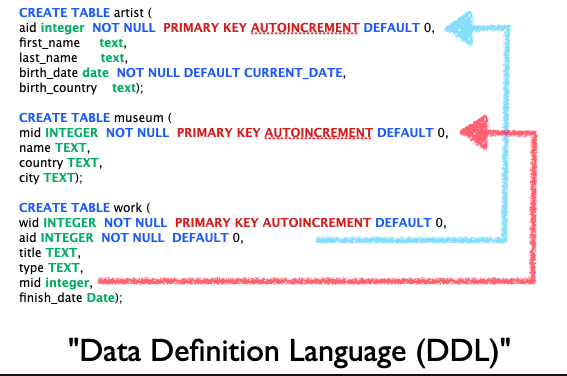

## Loading in some data

In [ ]:
%%bash
# you can issue each of these commands interactively in a terminal if you'd like
sqlite3 art.db ".read art-load.sql" ".header on" ".mode column" "select * from work;"

"Data Manipulation Language (DML)"

```SQL
select * from tablename;
```


## Basic Queries in SQL

```SQL
select * from work;
```

*gets all rows from table work and prints out all columns*

```SQL
select title,type from work;
```

*gets all rows from table work and prints selected columns*

```SQL
select title,type as "work type" from work;
```
*gets all rows from table work and prints selected columns,
renaming the second one (view only)*

```SQL
select title,DATE('NOW') - finish_date as age from work where 
finish_date > DATE("1970-01-01")
order by age;
```
*get only those rows where the work was finished before 1970, and show the name and age in years, descending order by age*

## Basic Queries in SQL

We can use the ipython SQL magic:

```bash
pip install ipython-sql
```
cf. https://pypi.org/project/ipython-sql/

In [ ]:
%load_ext sql
%config SqlMagic.displaycon = False
%sql sqlite:///art.db

In [ ]:
%sql select * from work where type = 'painting'

In [ ]:
%sql select * from work where type like 'painting'

In [ ]:
%sql select * from work where type glob 'P*'

In [ ]:
%sql select * from work where type glob '*[p|P]rint*'

*Small exercise:*
    
What work was created less than 45 years ago and starts with the letter "S"?

In [ ]:
%sql select * from work where title glob 'S*' AND DATE('NOW') - finish_date < 45

**What if I want to view all works in Berkeley by American artists?**

This information is distributed across three different tables

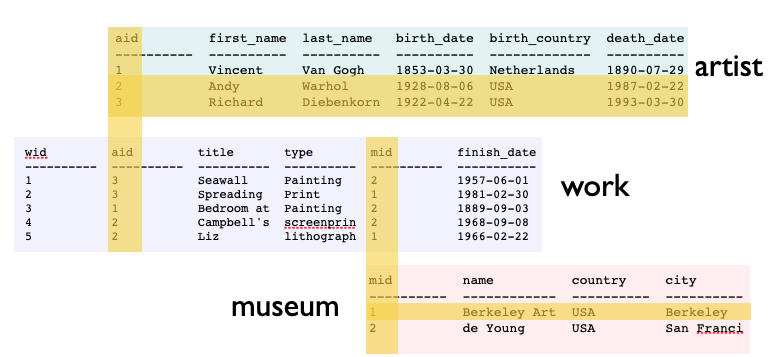

SQL: JOIN (after SELECT, before WHERE)

In [ ]:
%%sql
select museum.name as museum, artist.last_name as artist,
        work.title,work.type,work.finish_date as date from work
 JOIN artist on artist.aid = work.aid
 JOIN museum on museum.mid = work.mid
 where artist.birth_country = 'USA' 
   and museum.city = 'Berkeley';

In [ ]:
%%sql sqlite:///authors.db
CREATE TABLE writer (first_name, last_name, year_of_death);
INSERT INTO writer VALUES ('William', 'Shakespeare', 1616);
INSERT INTO writer VALUES ('Bertold', 'Brecht', 1956);
INSERT INTO writer VALUES ('Wes', 'McKinney', Null);

In [ ]:
%%sql
select * from writer

In [ ]:
result = %sql SELECT * FROM writer WHERE year_of_death > 1605

In [ ]:
dataframe = result.DataFrame() 
dataframe

In [ ]:
%matplotlib inline
import seaborn as sns
result.bar()

## More Advanced Concepts

**Views**

"virtual tables" that are the result of a (complex) query on the tables. Like "Smart Folders"

**Triggers**

built in actions that the DB takes on itself when something it done to it. E.g., log all the insert actions in a separate log table

**Transactions**

series of DB interactions that can be committed "all at once" or "rolledback" if there is a problem